In [9]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

In [10]:
# read in the json file for the totalbinary case

path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'), 'dataset.json')
assert os.path.exists(path)

import json

with open(path, 'r') as f:
    dataset = json.load(f)

In [11]:
ctvn = dataset['labels']['ctvn']
ctvp = dataset['labels']['ctvp']
anorectum = dataset['labels']['anorectum']
vagina = dataset['labels']['vagina']
uterus = dataset['labels']['uterus']

In [12]:
# subset of ids that appear in all 3

overlap = set(set(ctvn) & set(ctvp)).union(set(ctvn) & set(anorectum)).union(set(ctvp) & set(anorectum))
overlap = sorted(list(overlap))
print(overlap)

[9, 10, 19, 29, 30, 34, 35, 36, 37, 38, 39, 40, 44, 54, 55, 56, 64, 65, 66, 67, 68, 69, 70, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [13]:
overlap_frequency = {i: [] for i in overlap}

In [14]:
from itertools import chain, combinations
import json

def powerset(iterable):
    # powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

n_labels = 7

labelscomb = list(powerset(range(1,n_labels + 1)))
multilabels = range(len(labelscomb))
labelscomb_to_multilabel = dict(zip(labelscomb, multilabels))

# So `labelscomb_to_multilabel` is basically a look-up table for converting a combination
# of labels to the huge integer value that will be used in the nnU-Net nifti label file.
labelscomb_to_multilabel

{(): 0,
 (1,): 1,
 (2,): 2,
 (3,): 3,
 (4,): 4,
 (5,): 5,
 (6,): 6,
 (7,): 7,
 (1, 2): 8,
 (1, 3): 9,
 (1, 4): 10,
 (1, 5): 11,
 (1, 6): 12,
 (1, 7): 13,
 (2, 3): 14,
 (2, 4): 15,
 (2, 5): 16,
 (2, 6): 17,
 (2, 7): 18,
 (3, 4): 19,
 (3, 5): 20,
 (3, 6): 21,
 (3, 7): 22,
 (4, 5): 23,
 (4, 6): 24,
 (4, 7): 25,
 (5, 6): 26,
 (5, 7): 27,
 (6, 7): 28,
 (1, 2, 3): 29,
 (1, 2, 4): 30,
 (1, 2, 5): 31,
 (1, 2, 6): 32,
 (1, 2, 7): 33,
 (1, 3, 4): 34,
 (1, 3, 5): 35,
 (1, 3, 6): 36,
 (1, 3, 7): 37,
 (1, 4, 5): 38,
 (1, 4, 6): 39,
 (1, 4, 7): 40,
 (1, 5, 6): 41,
 (1, 5, 7): 42,
 (1, 6, 7): 43,
 (2, 3, 4): 44,
 (2, 3, 5): 45,
 (2, 3, 6): 46,
 (2, 3, 7): 47,
 (2, 4, 5): 48,
 (2, 4, 6): 49,
 (2, 4, 7): 50,
 (2, 5, 6): 51,
 (2, 5, 7): 52,
 (2, 6, 7): 53,
 (3, 4, 5): 54,
 (3, 4, 6): 55,
 (3, 4, 7): 56,
 (3, 5, 6): 57,
 (3, 5, 7): 58,
 (3, 6, 7): 59,
 (4, 5, 6): 60,
 (4, 5, 7): 61,
 (4, 6, 7): 62,
 (5, 6, 7): 63,
 (1, 2, 3, 4): 64,
 (1, 2, 3, 5): 65,
 (1, 2, 3, 6): 66,
 (1, 2, 3, 7): 67,
 (1, 2, 4, 5): 

In [15]:
import numpy as np

def operation(x):
        labels_in_voxel = tuple(np.argwhere(x)[:, 0] + 1)
        return labelscomb_to_multilabel[labels_in_voxel]

def image_to_nnunet_multilabel(input_volume):
    # Note `input_volume` should be one-hot encoded, so input_volume.shape == (n_labels, D, H, W)
    input_volume_per_channel = input_volume.reshape(n_labels, -1).T # (D x H x W, n_labels)
    print('starting operation')
    input_volume_translated = np.apply_along_axis(operation, 1, input_volume_per_channel)
    print('done operation')
    correct_shape = input_volume_translated.reshape(input_volume.shape[1:]) # (D, H, W)
    
    return correct_shape

In [16]:
# read in the ground truth labels for the totalbinary case and select the frequency of each id

# maybe do with original trainer?
# don't forget to do with total segmentator also

path = os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('TotalBinary'), 'nnUNetTrainer_500epochs__totseg_nnUNetPlans__3d_fullres')
labels = sorted([f for f in os.listdir(path) if f.endswith('.npz')])

import SimpleITK as sitk
import numpy as np

from tqdm import tqdm

for label in tqdm(labels):
    label_path = os.path.join(path, label)
    
    img = np.load(label_path)['probabilities']
    # threshold the prediction
    img = (img > 0.5).astype(np.uint8)
    # convert to a multilabel image
    img = image_to_nnunet_multilabel(img)    
    
    # count the number of non zero elements
    number_of_voxels = np.count_nonzero(img)

    for i in overlap:
        overlap_frequency[i].append((np.sum(img == i), number_of_voxels))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
import json

# dump the overlap_frequency to a json file
with open('overlap_frequency_nnunet_baseline.json', 'w') as f:
    json.dump(overlap_frequency, f, cls=NpEncoder)

In [ ]:
print(overlap_frequency[9])

[(0, 578185), (0, 465500), (0, 477121), (2667, 635349), (0, 396560), (0, 298257), (0, 413339), (20, 364334), (0, 463957), (0, 208392), (37, 279087), (117, 309538), (1207, 456055), (0, 354309), (0, 488445), (0, 275831), (147, 419378), (0, 535679), (0, 324503), (95, 458722), (35, 319525), (0, 515787), (36, 555998), (1, 433367), (0, 587574), (435, 485007), (0, 664769), (116, 392950), (0, 533551), (2, 496828), (0, 325640), (0, 323310), (0, 478639), (0, 586075), (0, 305392), (0, 499972), (0, 601191), (0, 532916), (0, 483201), (6, 669311), (0, 579570), (0, 264706), (0, 633410), (0, 617820), (0, 318488), (255, 700279), (0, 552797), (0, 445652), (1, 602751), (0, 519969), (0, 409289), (0, 362659), (0, 346772), (0, 318242), (0, 153281), (0, 690698), (0, 393935), (2, 403750), (2385, 773095), (488, 573701), (0, 349896), (0, 549107), (0, 477755), (0, 361063), (0, 379723), (117, 407834), (0, 543477), (847, 757722), (3, 507178), (0, 702582), (0, 626443), (0, 347365), (10, 276005), (0, 687753), (0, 28

In [ ]:
number_of_ocurrences = {i: sum([j[0] for j in overlap_frequency[i]]) for i in overlap}
percentage_of_ocurrences = {i: 0 for i in overlap}

for i in overlap:
    percentage_of_ocurrences[i] = number_of_ocurrences[i] / sum([j[1] for j in overlap_frequency[i]])

In [ ]:
percentage_of_ocurrences

{9: 0.00019669426032472884,
 10: 0.0,
 19: 1.1971248303787385e-05,
 29: 0.0,
 30: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 44: 0.0,
 54: 1.2054381972563686e-06,
 55: 0.0015907004017829429,
 56: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 94: 0.0009634360874485556,
 95: 0.0,
 96: 0.0,
 99: 0.0,
 100: 0.0,
 101: 0.0,
 102: 0.0,
 103: 0.0,
 104: 0.0,
 105: 0.0,
 106: 0.0,
 107: 0.0,
 109: 0.0,
 110: 0.0,
 111: 0.0,
 112: 0.0,
 113: 0.0,
 114: 0.0,
 115: 0.0,
 116: 0.0,
 119: 0.0,
 120: 0.0,
 121: 0.0,
 122: 0.0,
 123: 0.0,
 124: 0.0,
 125: 0.0,
 126: 0.0,
 127: 0.0}

In [ ]:
non_zero_ocurrences = {k: v for (k,v) in number_of_ocurrences.items() if v != 0}
non_zero_ocurrences

{9: 9464, 19: 576, 54: 58, 55: 76537, 94: 46356}

In [ ]:
# translated to the combo of words

def reverse_lookup_id(id):
    # given a dictinoary of key: anatomy, and value: segmentation ids, reverse the lookup to get the list of anatomies that match the id.
    anatomies = []

    if type(id) == int:
        for k, v in dataset['labels'].items():
            if k == 'background':
                if id == v:
                    anatomies.append('background')
            elif id in v:
                anatomies.append(k)
            
    elif type(id) == list:
        for k, v in dataset['labels'].items():
            if k == 'background' and 0 in id:
                anatomies.append('background')
            elif any([i in v for i in id]):
                anatomies.append(k)
    else:
        raise TypeError('Huh? Whats the type of id? needs to be int or list of ints ', id)

    return anatomies

assert reverse_lookup_id(0) == ['background']
assert reverse_lookup_id(1) == ['anorectum']
assert reverse_lookup_id(100) == ['anorectum', 'bladder', 'ctvn', 'ctvp', 'uterus']
assert reverse_lookup_id([0,1]) == ['background', 'anorectum']

def get_id_from_label(str_id):
    return ['anorectum','bladder','ctvn','ctvp','parametrium','uterus','vagina','totalbinary'][str_id]

assert get_id_from_label(0) == 'anorectum'
assert get_id_from_label(7) == 'totalbinary'

In [ ]:
type_of_overlap_non_zero = []
frequency_of_overlap_non_zero = []
percentage_of_overlap_non_zero = []

for k,v in non_zero_ocurrences.items():
    type_of_overlap_non_zero.append(', '.join(reverse_lookup_id(k)))
    frequency_of_overlap_non_zero.append(v)
    percentage_of_overlap_non_zero.append(percentage_of_ocurrences[k])

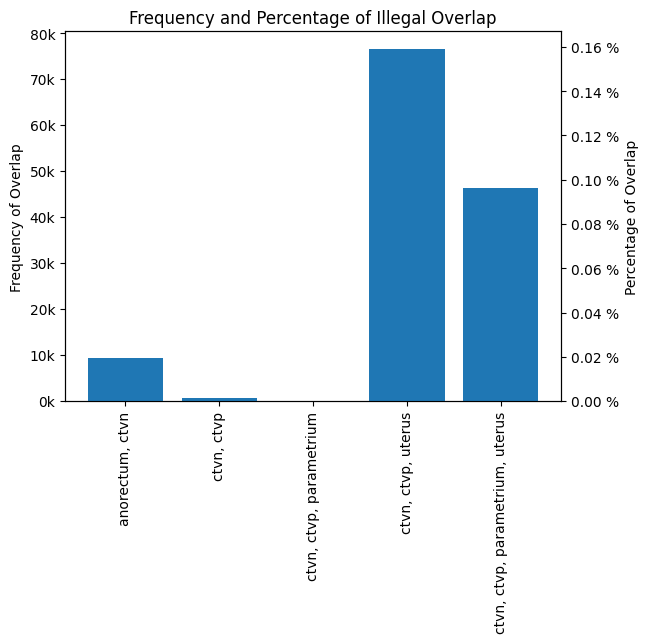

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()

# Plot the frequency of overlap on the primary y-axis (left-hand side)
ax1.bar(type_of_overlap_non_zero, frequency_of_overlap_non_zero, )
ax1.set_ylabel('Frequency of Overlap')
ax1.tick_params(axis='x', rotation=90)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))

# Create a secondary y-axis (right-hand side) that shares the same x-axis
ax2 = ax1.twinx()
ax2.bar(type_of_overlap_non_zero, percentage_of_overlap_non_zero)
ax2.set_ylabel('Percentage of Overlap')
ax2.tick_params(axis='y')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 100:.2f} %'))

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.title('Frequency and Percentage of Illegal Overlap')

# Display the plot
plt.show()